In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from collections import defaultdict
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform

In [4]:
path_train = "train_diabet.csv"
train_y = "train_Y_diabet.csv"

In [5]:
df = pd.read_csv(path_train)
df_train_y = pd.read_csv(train_y)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HighBP,47363.0,0.563879,0.495908,0.0,0.0,1.0,1.0,1.0
HighChol,47363.0,0.523468,0.499454,0.0,0.0,1.0,1.0,1.0
CholCheck,47363.0,0.975741,0.153855,0.0,1.0,1.0,1.0,1.0
BMI,47363.0,29.862551,7.144498,12.0,25.0,29.0,33.0,98.0
Smoker,47363.0,0.475118,0.499386,0.0,0.0,0.0,1.0,1.0
Stroke,47363.0,0.062834,0.242666,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,47363.0,0.148766,0.355861,0.0,0.0,0.0,0.0,1.0
PhysActivity,47363.0,0.701940,0.457411,0.0,0.0,1.0,1.0,1.0
Fruits,47363.0,0.610814,0.487571,0.0,0.0,1.0,1.0,1.0
Veggies,47363.0,0.788844,0.408133,0.0,1.0,1.0,1.0,1.0


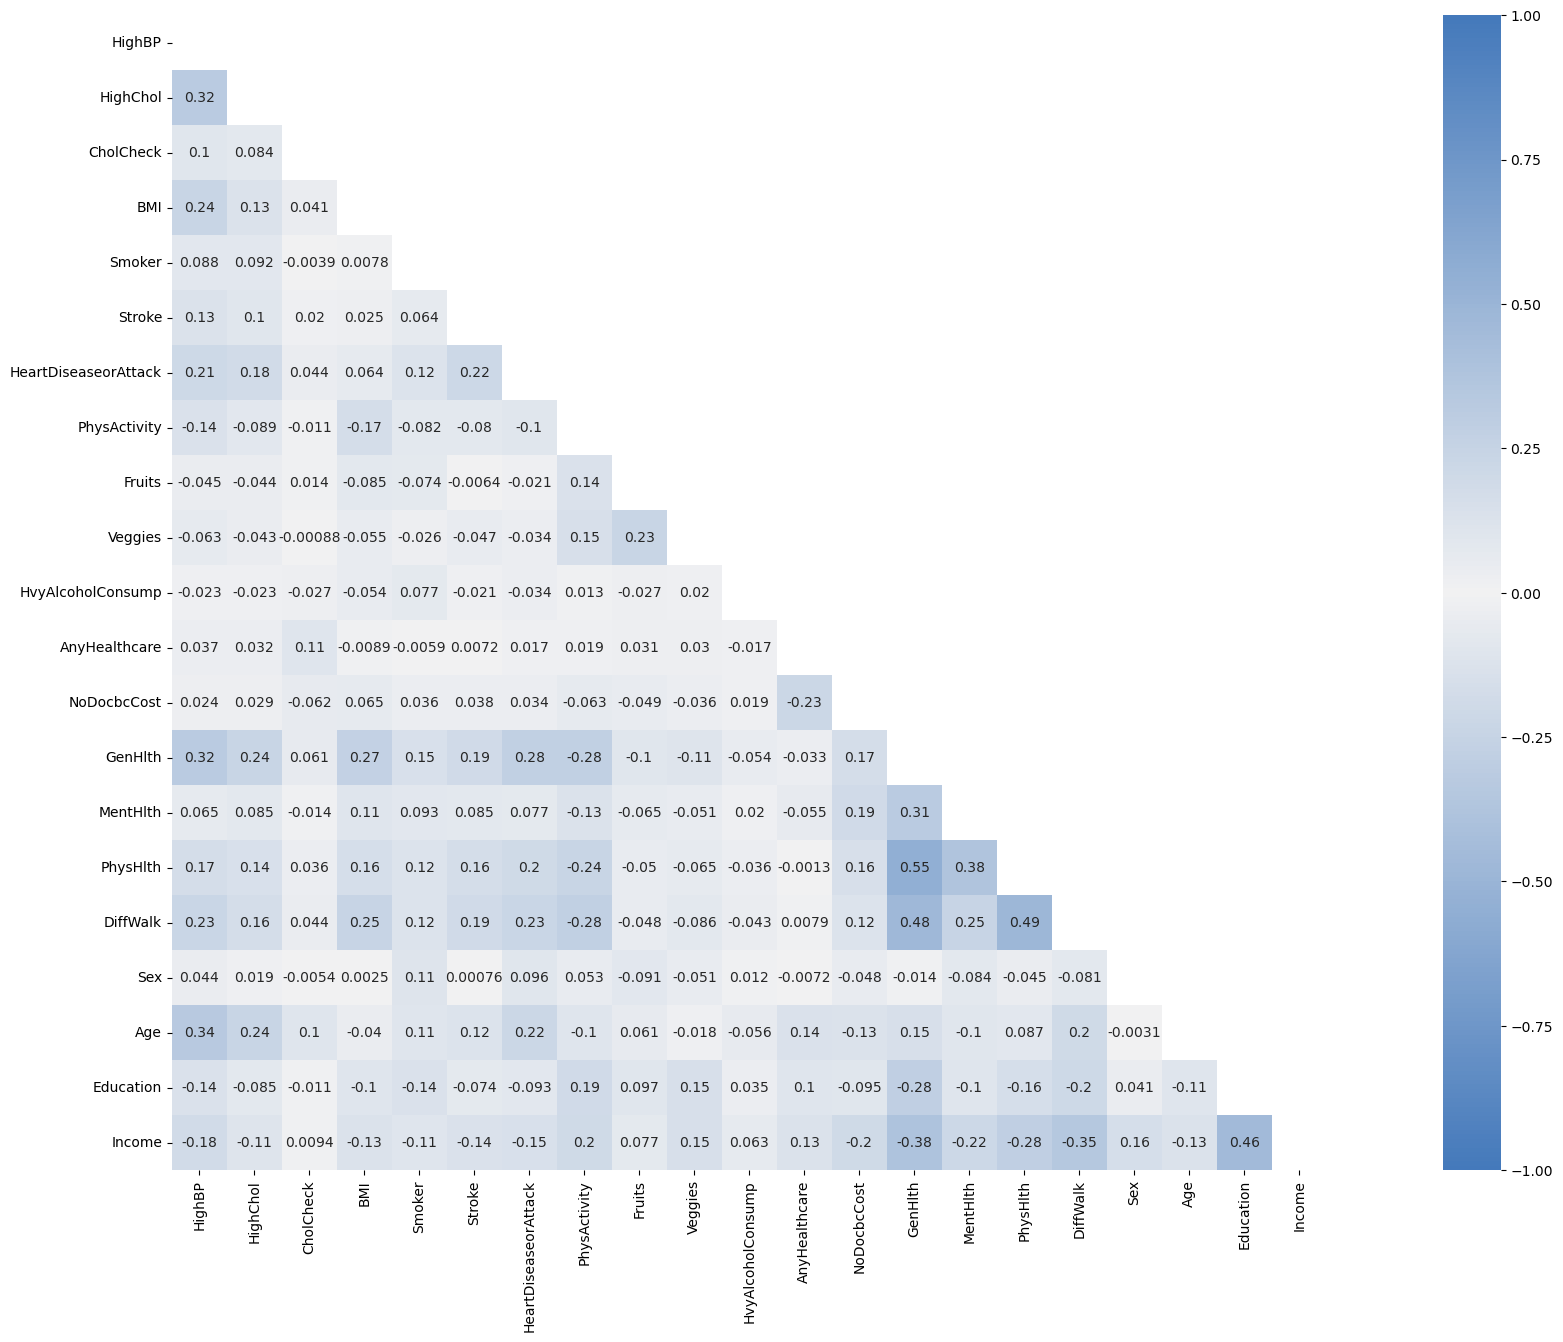

In [6]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),
    annot = True,
    vmin=-1.0, vmax=1.0,
    square=True,
    ax=ax);

In [7]:
data = pd.concat([df, df_train_y], axis=1)
data = data.drop_duplicates()
X, y = data.drop("Diabetes_binary", axis=1), data["Diabetes_binary"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
numerical_features = ['BMI', 'MentHlth', 'PhysHlth'] # числовые признаки, их надо масштабировать
ordinal_features = ['GenHlth', 'Age', 'Education', 'Income'] # многоклассовые признаки, их оставляем как есть
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
                   'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'] # категориальные признаки, их не трогаем

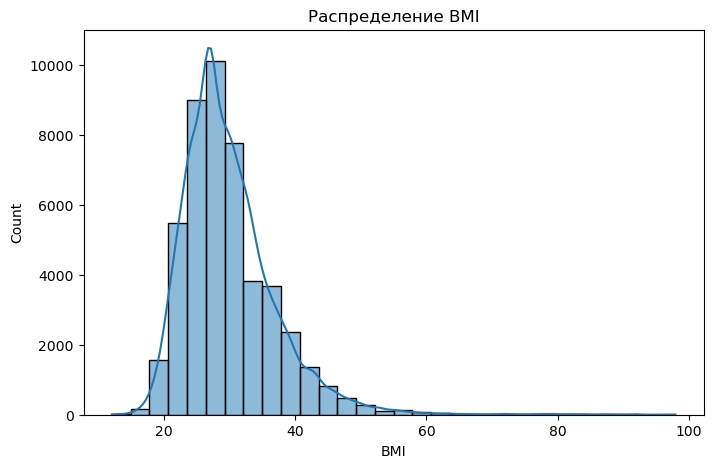

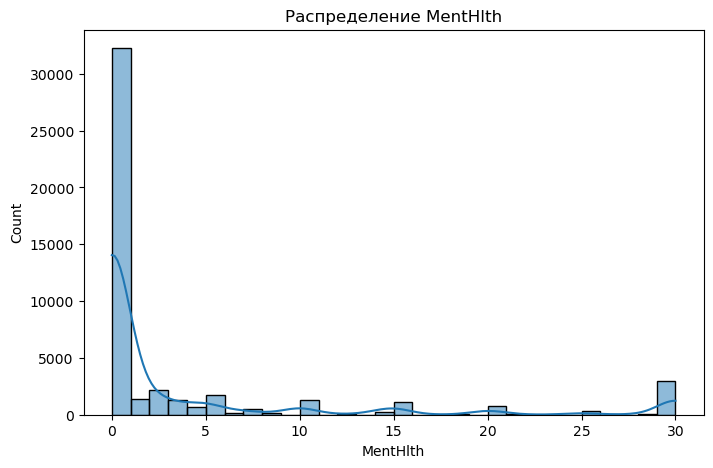

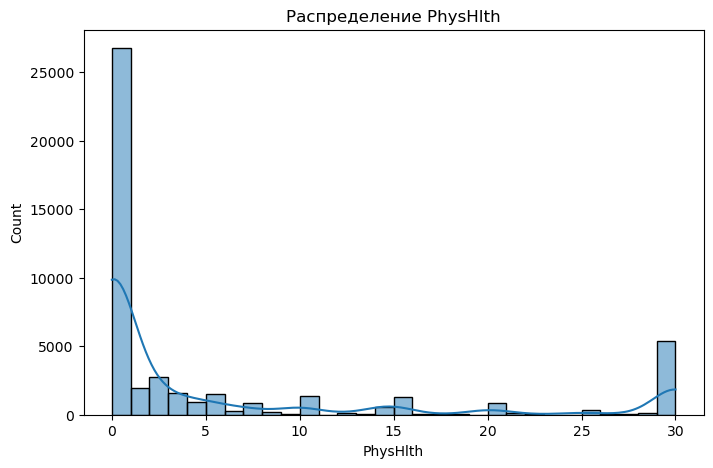

In [10]:
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
    plt.show()

In [11]:
# логарифмическое преобразование для сильно смещенных признаков
for col in ['MentHlth', 'PhysHlth']:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

scaler = MinMaxScaler()
X_train['BMI'] = scaler.fit_transform(X_train[['BMI']])
X_test['BMI'] = scaler.transform(X_test[['BMI']])

## Сделаем метрику, по которой будем оценивать модели

##### будем еще F_beta (β=2) смотреть

In [12]:
def my_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    weighted_error = fp + 2 * fn
    return -weighted_error

my_scorer = make_scorer(my_metric, greater_is_better=False)

### RandomForestClassifier

Метрика ошибок RandomForestClassifier: -2986
F_2_score RandomForestClassifier: 0.8490
F_√2_score RandomForestClassifier: 0.8112


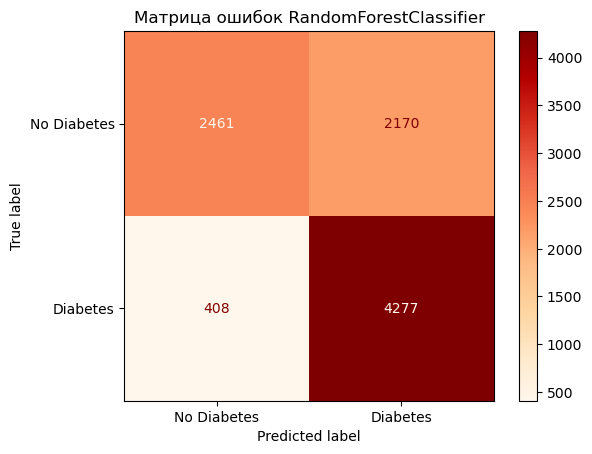

In [13]:
rfm_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 2},
    n_jobs=-1,
    random_state=42
)
rfm_model.fit(X_train, y_train)
y_pred_rfm = rfm_model.predict(X_test)

f_beta_rfm1 = fbeta_score(y_test, y_pred_rfm, beta = 2)
f_beta_rfm2 = fbeta_score(y_test, y_pred_rfm, beta = np.sqrt(2))

print(f"Метрика ошибок RandomForestClassifier: {my_metric(y_test, y_pred_rfm)}")
print(f"F_2_score RandomForestClassifier: {f_beta_rfm1:.4f}")
print(f"F_√2_score RandomForestClassifier: {f_beta_rfm2:.4f}")

cm = confusion_matrix(y_test, y_pred_rfm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="OrRd", values_format="d")
plt.title("Матрица ошибок RandomForestClassifier")
plt.show()

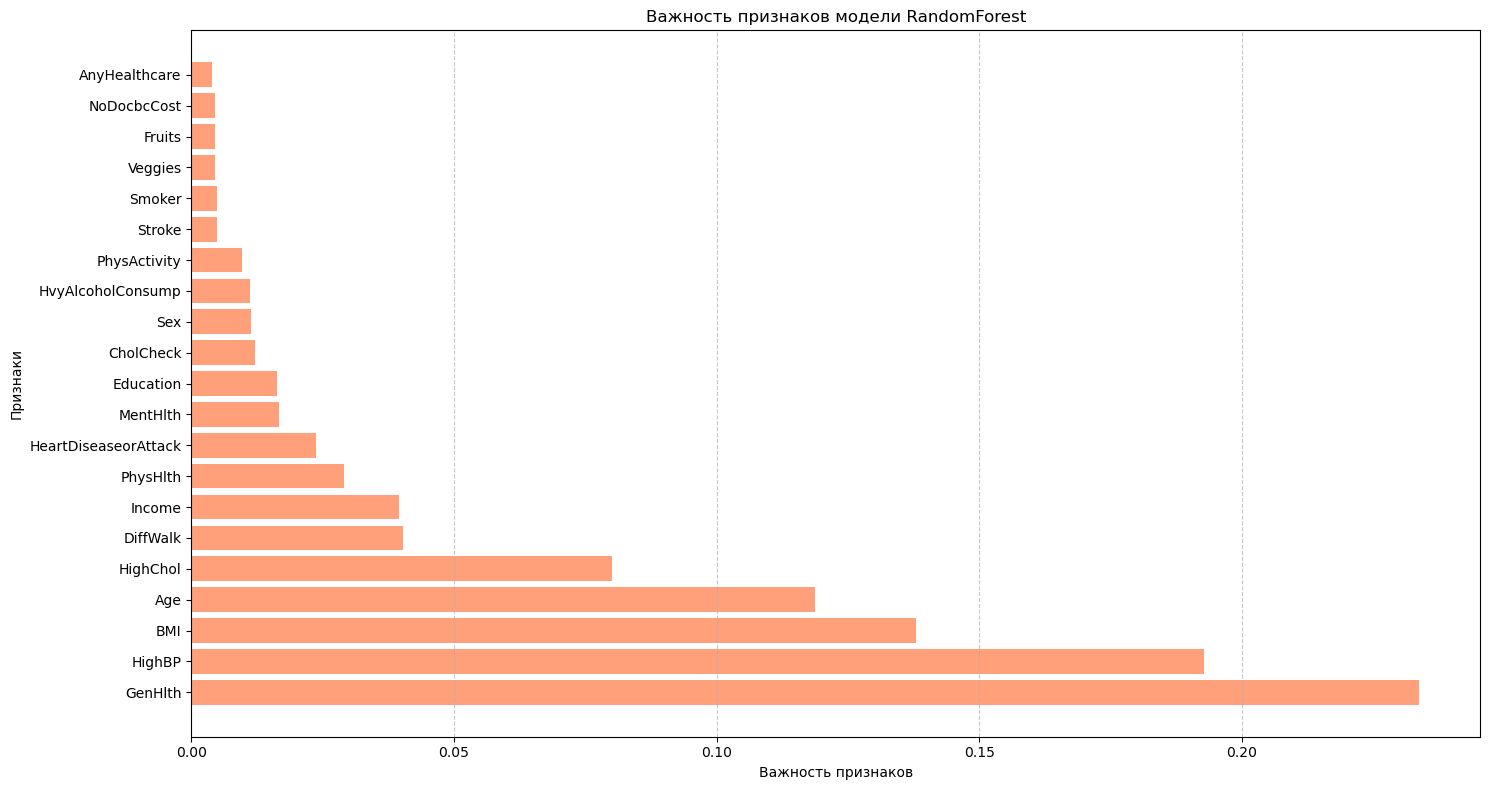

In [14]:
feature_importances = rfm_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(15, 8))
plt.barh(y=sorted_features, width=sorted_importances, color='lightsalmon')
plt.xlabel("Важность признаков")
plt.ylabel("Признаки")
plt.title("Важность признаков модели RandomForest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.gca().invert_yaxis()
plt.show()

#### Попробуем удалить незначимые признаки, проверим их через дендрагармму

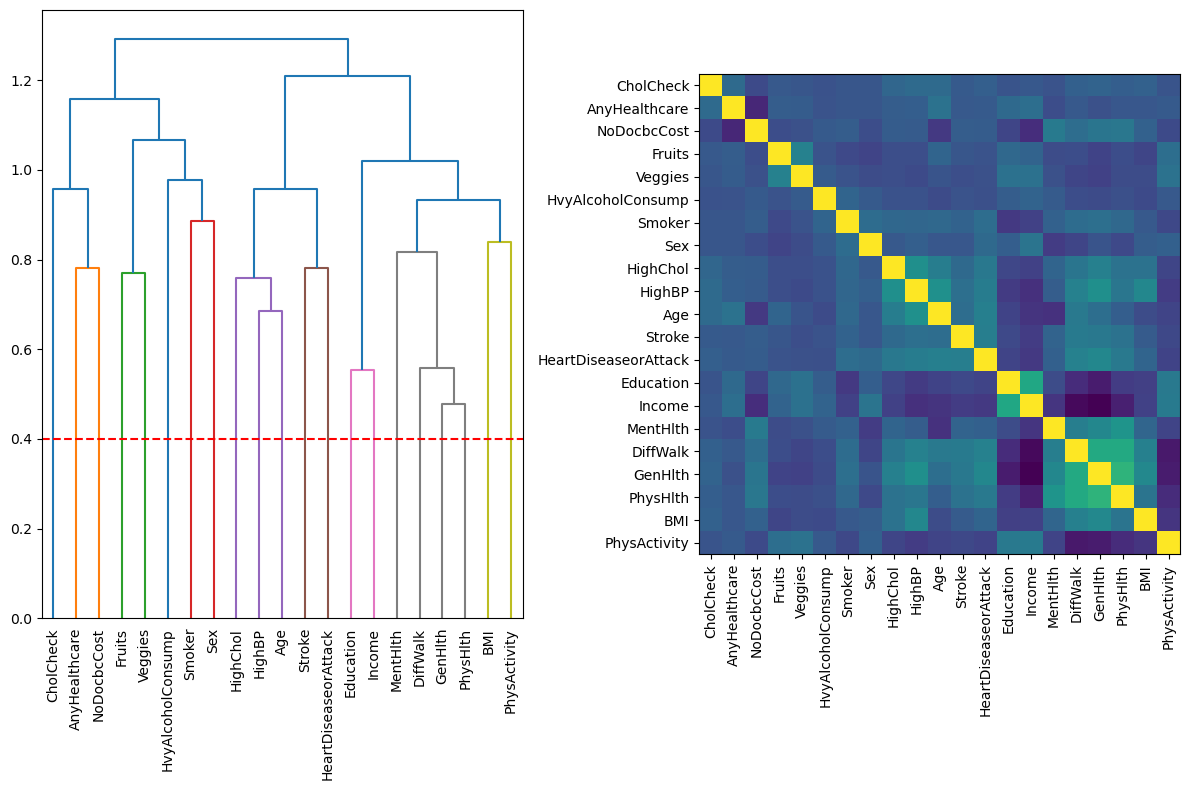

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = feature_names,
    ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax1.axhline(y=0.4, color='r', linestyle='--')

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(feature_names[dendro["leaves"]], rotation="vertical")
ax2.set_yticklabels(feature_names[dendro["leaves"]])
fig.tight_layout()
plt.show()

Метрика F_beta (β=2) на тестовых данных с удаленными признаками: 0.8123
Метрика ошибок: -2981


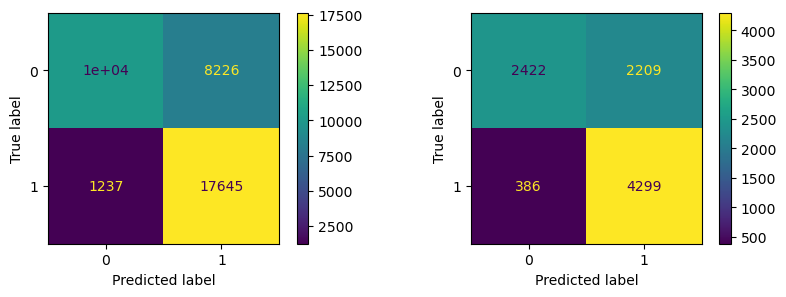

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


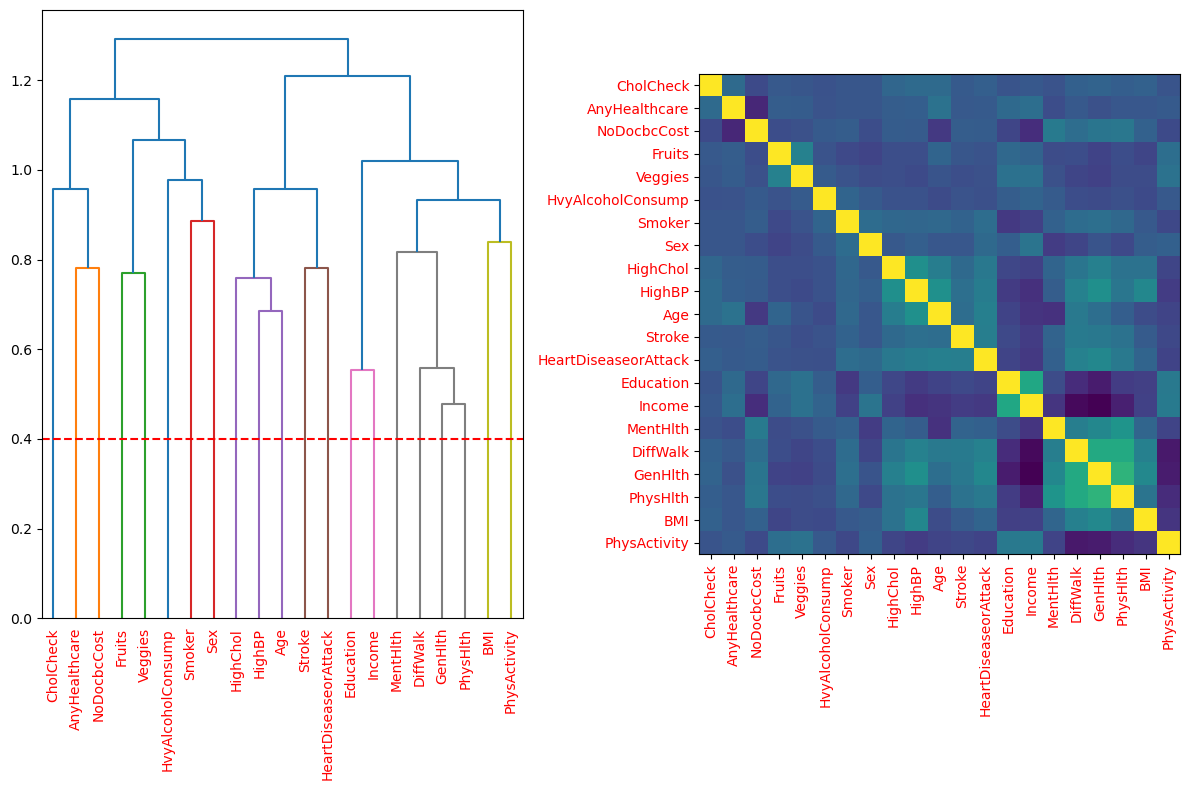

In [16]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.4, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_columns = X_train.columns[selected_features]

X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

clf_sel = RandomForestClassifier(n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=1,
    bootstrap=False,
    class_weight={0: 1, 1: 2},
    n_jobs=-1,
    random_state=42)
clf_sel.fit(X_train_sel, y_train)

y_pred_train = clf_sel.predict(X_train_sel)
y_pred = clf_sel.predict(X_test_sel)

f_beta_score = fbeta_score(y_test, y_pred, beta=np.sqrt(2))

print(f"Метрика F_beta (β=2) на тестовых данных с удаленными признаками: {f_beta_score:.4f}")
print(f"Метрика ошибок: {my_metric(y_test, y_pred)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred_train)).plot(ax=ax1);
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(ax=ax2);
plt.show();


selected_features_names = feature_names[selected_features]

print(selected_features)
print(selected_features_names)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = feature_names,
    ax=ax1, leaf_rotation=90
)

ax1.axhline(y=0.4, color='r', linestyle='--')

[ax1.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(feature_names[dendro["leaves"]], rotation="vertical")
ax2.set_yticklabels(feature_names[dendro["leaves"]])
fig.tight_layout()
[ax2.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];
[ax2.get_yticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];
plt.show()

#### В итоге получили, что лучшая метрика получается при пороге 0.4, то есть без удаления признаков

### ExtraTreesClassifier

Метрика ошибок ExtraTreesClassifier: -3075
F_2_score ExtraTreesClassifier: 0.8475
F_√2_score ExtraTreesClassifier: 0.8072


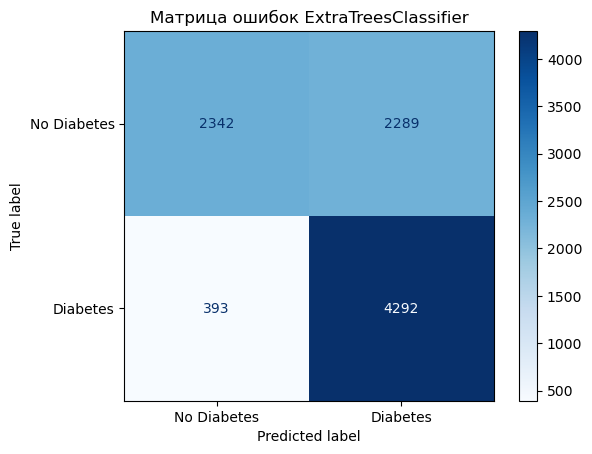

In [17]:
et_model = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=2,
    bootstrap=True,
    class_weight={0: 1, 1: 2},
    n_jobs= -1,
    random_state=42
)
et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_test)

f_beta_et1 = fbeta_score(y_test, y_pred_et, beta = 2)
f_beta_et2 = fbeta_score(y_test, y_pred_et, beta = np.sqrt(2))

print(f"Метрика ошибок ExtraTreesClassifier: {my_metric(y_test, y_pred_et)}")
print(f"F_2_score ExtraTreesClassifier: {f_beta_et1:.4f}")
print(f"F_√2_score ExtraTreesClassifier: {f_beta_et2:.4f}")

cm = confusion_matrix(y_test, y_pred_et)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок ExtraTreesClassifier")
plt.show()

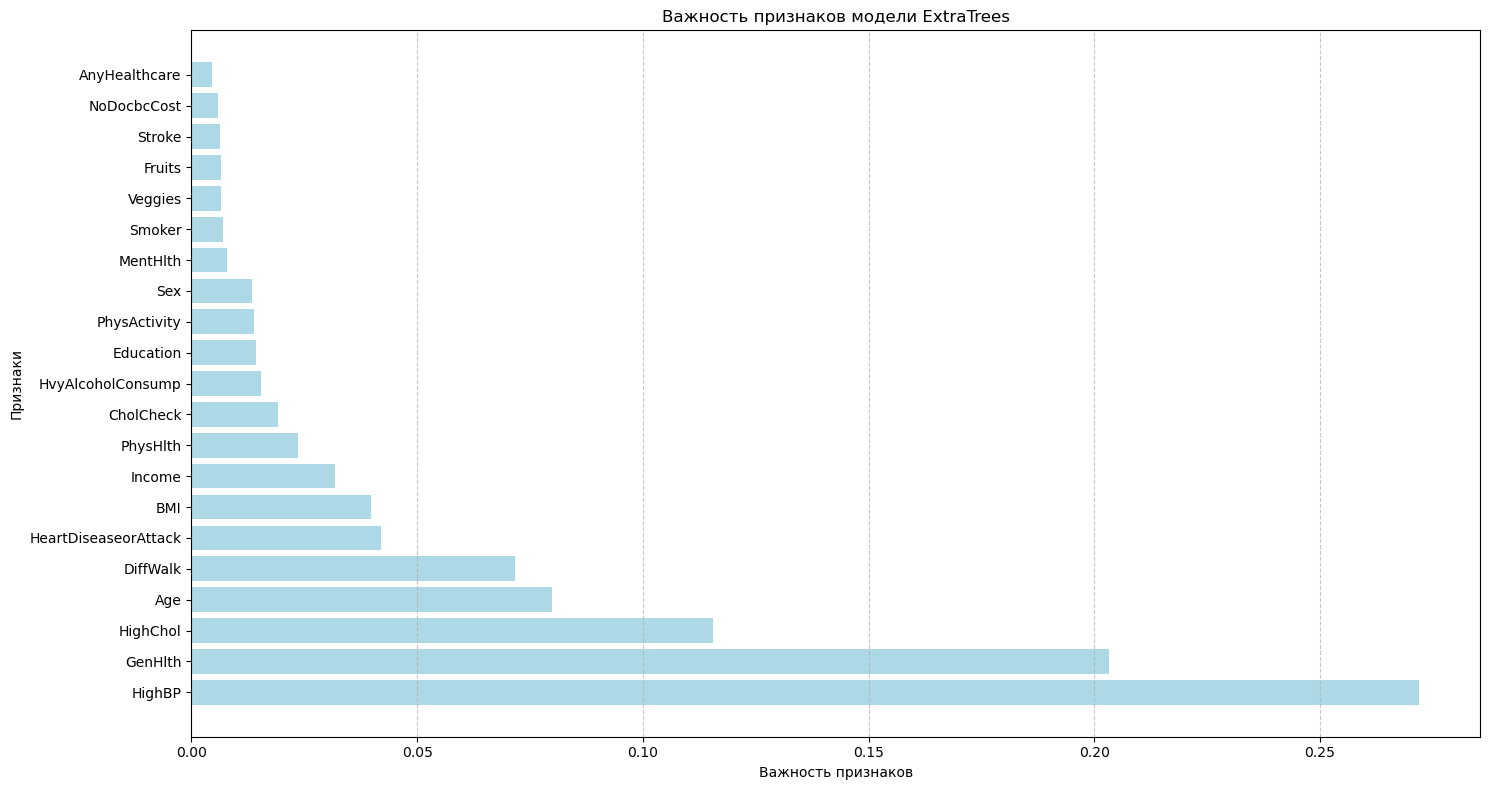

In [18]:
feature_importances = et_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(15, 8))
plt.barh(y=sorted_features, width=sorted_importances, color='lightblue')
plt.xlabel("Важность признаков")
plt.ylabel("Признаки")
plt.title("Важность признаков модели ExtraTrees")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.gca().invert_yaxis()
plt.show()

#### Обе модели работают хорошо, но возьмем `RandomForestClassifier`, потому что там выше метрика

### GradientBoostingClassifier

Метрика ошибок GradientBoostingClassifier: -3299
F_2_score GradientBoostingClassifier: 0.7822
F_√2_score GradientBoostingClassifier: 0.7725


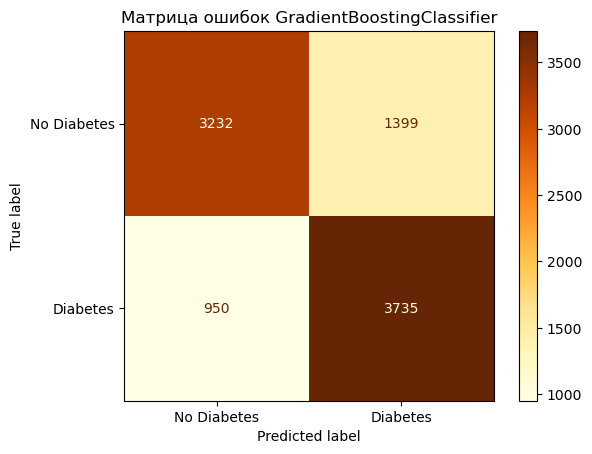

In [19]:
gbc_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=5,
    subsample=0.667,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42
)
gbc_model.fit(X_train, y_train)
y_pred_gbc = gbc_model.predict(X_test)

f_beta_gbc1 = fbeta_score(y_test, y_pred_gbc, beta = 2)
f_beta_gbc2 = fbeta_score(y_test, y_pred_gbc, beta = np.sqrt(2))

print(f"Метрика ошибок GradientBoostingClassifier: {my_metric(y_test, y_pred_gbc)}")
print(f"F_2_score GradientBoostingClassifier: {f_beta_gbc1:.4f}")
print(f"F_√2_score GradientBoostingClassifier: {f_beta_gbc2:.4f}")

cm_display = ConfusionMatrixDisplay.from_estimator(
    gbc_model, X_test, y_test, display_labels=["No Diabetes", "Diabetes"], cmap="YlOrBr", values_format="d"
)
plt.title("Матрица ошибок GradientBoostingClassifier")
plt.show()

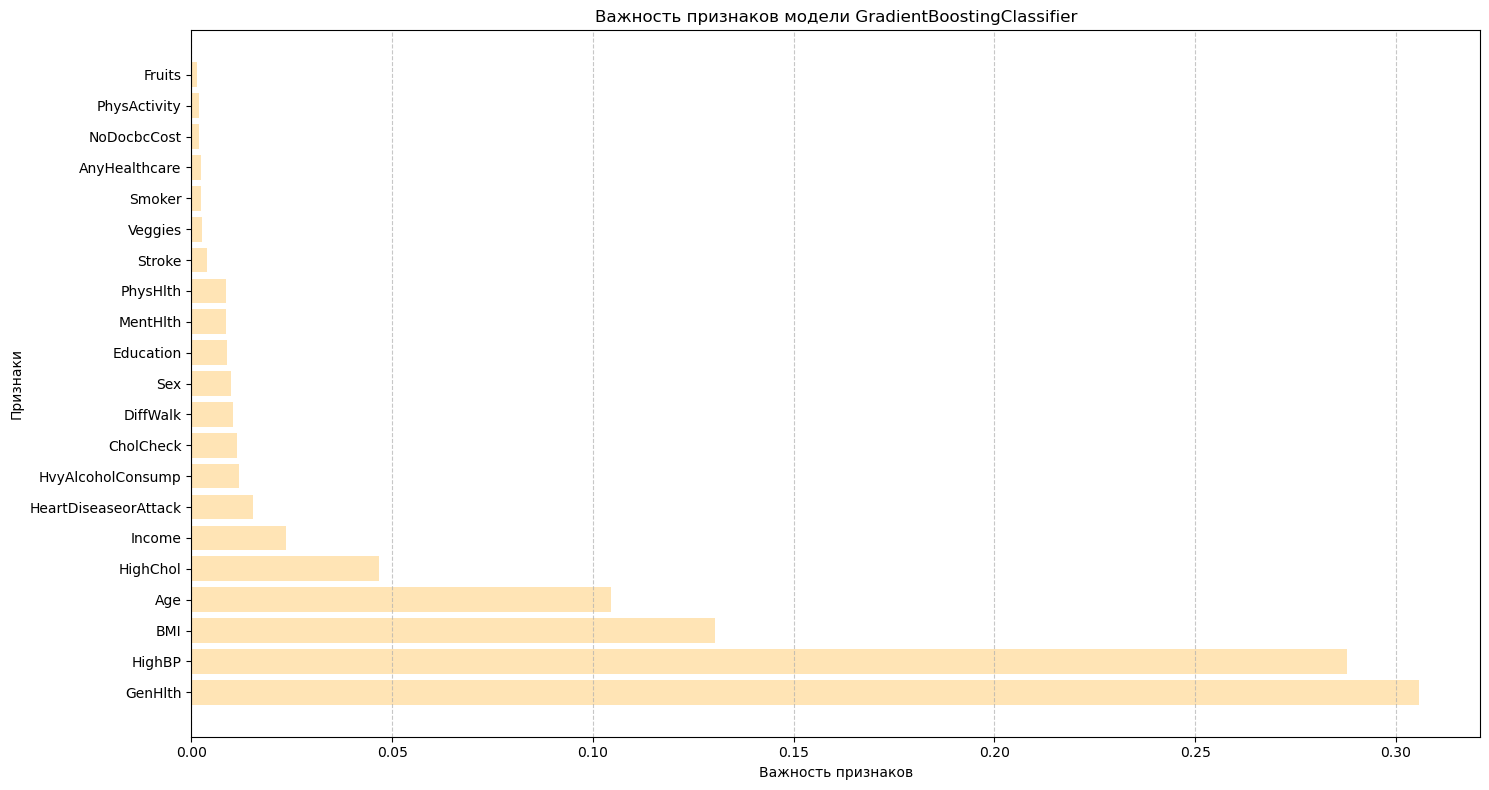

In [20]:
feature_importances = gbc_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(15, 8))
plt.barh(y=sorted_features, width=sorted_importances, color='moccasin')
plt.xlabel("Важность признаков")
plt.ylabel("Признаки")
plt.title("Важность признаков модели GradientBoostingClassifier")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.gca().invert_yaxis()
plt.show()

### HistGradientBoostingClassifier

Метрика ошибок HistGradientBoostingClassifier: -3263
F_2_score HistGradientBoostingClassifier: 0.7873
F_√2_score HistGradientBoostingClassifier: 0.7761


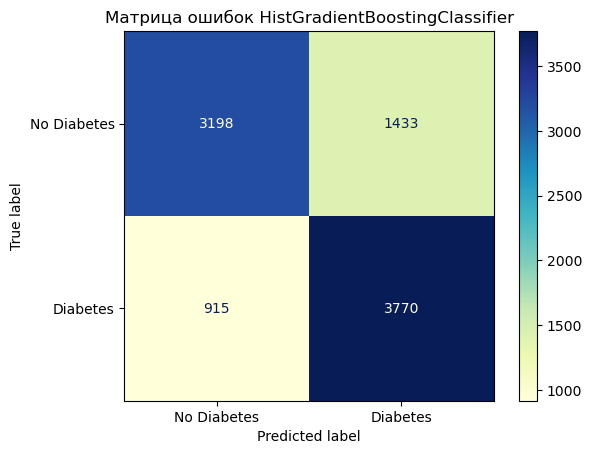

In [21]:
hgbc_model = HistGradientBoostingClassifier(
    max_iter=110,
    learning_rate=0.05,
    max_depth=5,
    max_leaf_nodes=40,
    min_samples_leaf=25,
    random_state=42
)
hgbc_model.fit(X_train, y_train)
y_pred_hgbc = hgbc_model.predict(X_test)

f_beta_hgbc1 = fbeta_score(y_test, y_pred_hgbc, beta = 2)
f_beta_hgbc2 = fbeta_score(y_test, y_pred_hgbc, beta = np.sqrt(2))

print(f"Метрика ошибок HistGradientBoostingClassifier: {my_metric(y_test, y_pred_hgbc)}")
print(f"F_2_score HistGradientBoostingClassifier: {f_beta_hgbc1:.4f}")
print(f"F_√2_score HistGradientBoostingClassifier: {f_beta_hgbc2:.4f}")

cm_display = ConfusionMatrixDisplay.from_estimator(
    hgbc_model, X_test, y_test, display_labels=["No Diabetes", "Diabetes"], cmap="YlGnBu", values_format="d"
)
plt.title("Матрица ошибок HistGradientBoostingClassifier")
plt.show()

## Делаем итоговую модель через Voting

Метрика ошибок Voting: -2960
F_2_score Voting: 0.8432
F_√2_score Voting: 0.8101


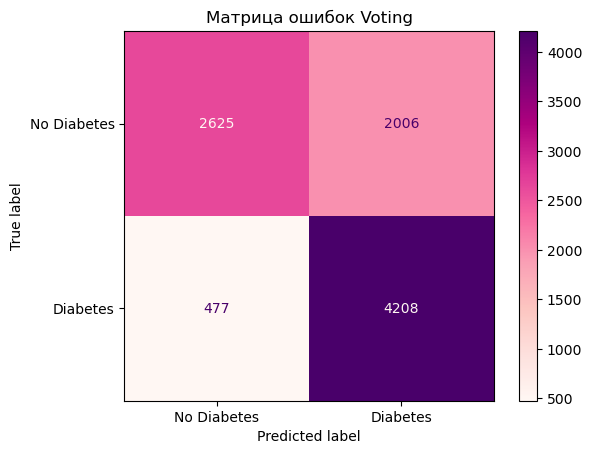

In [22]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 4},
    n_jobs=-1,
    random_state=42
)

knn_clf = KNeighborsClassifier(
    n_neighbors=35,
    p=1,
    weights='uniform',
    n_jobs=-1
)

hgb_clf = HistGradientBoostingClassifier(
    max_iter=110,
    learning_rate=0.05,
    max_depth=5,
    max_leaf_nodes=40,
    min_samples_leaf=25,
    random_state=42
)

lr_clf = LogisticRegression(
    C=0.1,
    solver='saga',
    class_weight='balanced',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('knn', knn_clf),
        ('hgb', hgb_clf),
        ('lr', lr_clf)
    ],
    voting='soft',
    weights=[7, 1, 3, 5]
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

f_beta_voting1 = fbeta_score(y_test, y_pred_voting, beta = 2)
f_beta_voting2 = fbeta_score(y_test, y_pred_voting, beta = np.sqrt(2))

print(f"Метрика ошибок Voting: {my_metric(y_test, y_pred_voting)}")
print(f"F_2_score Voting: {f_beta_voting1:.4f}")
print(f"F_√2_score Voting: {f_beta_voting2:.4f}")

cm_display = ConfusionMatrixDisplay.from_estimator(
    voting_clf, X_test, y_test, display_labels=["No Diabetes", "Diabetes"], cmap="RdPu", values_format="d"
)
plt.title("Матрица ошибок Voting")
plt.show()

### Эта модель работает наравне с RandomForestClassifier, но как будто она более устойчивая